In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize(os.cpu_count()-1, progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
data = pd.read_csv('./dataset/6.Pricing_Test/test_results.csv')
user = pd.read_csv('./dataset/6.Pricing_Test/user_table.csv')

In [3]:
# join two tables on user_id
data = data.merge(user, on='user_id', how='left')

In [4]:
data['timestamp'] = data['timestamp'].str.replace(':60:', ':59:')
data['timestamp'] = pd.to_datetime(data['timestamp'])

- About 10% of user_id is missing in user_table (city, country, lat, long). For now simply drop them

In [5]:
data = data.dropna()

In [6]:
def price_check(test, price):
    if test == 0 and price == 39: return True
    if test == 1 and price == 59: return True
    return False

data['price_check'] = data.parallel_apply(lambda x: price_check(x['test'], x['price']), axis=1)

In [7]:
data['price_check'].value_counts()

price_check
True     275294
False       322
Name: count, dtype: int64

- Few entities (~0.1%) are incorrect on price test. Simply remove them

In [8]:
data = data[data['price_check'] == True]

In [9]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 275294 entries, 0 to 316799
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           275294 non-null  int64         
 1   timestamp         275294 non-null  datetime64[ns]
 2   source            275294 non-null  object        
 3   device            275294 non-null  object        
 4   operative_system  275294 non-null  object        
 5   test              275294 non-null  int64         
 6   price             275294 non-null  int64         
 7   converted         275294 non-null  int64         
 8   city              275294 non-null  object        
 9   country           275294 non-null  object        
 10  lat               275294 non-null  float64       
 11  long              275294 non-null  float64       
 12  price_check       275294 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(5)
m

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_check
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,True
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,True
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,True
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,True
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,True


In [10]:
data['price'].value_counts()

price
39    176241
59     99053
Name: count, dtype: int64

<Axes: >

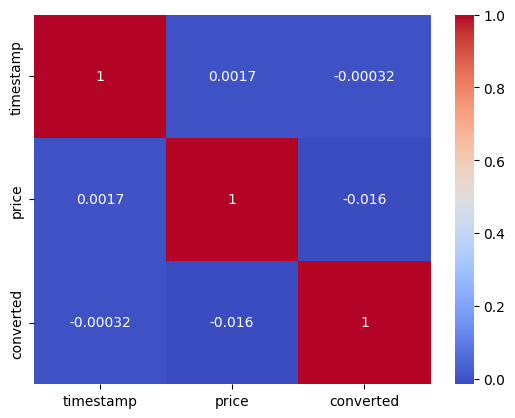

In [11]:
data_cor = data[['timestamp', 'price', 'converted']]
sns.heatmap(data_cor.corr(), annot=True, cmap='coolwarm')

<Axes: xlabel='operative_system', ylabel='count'>

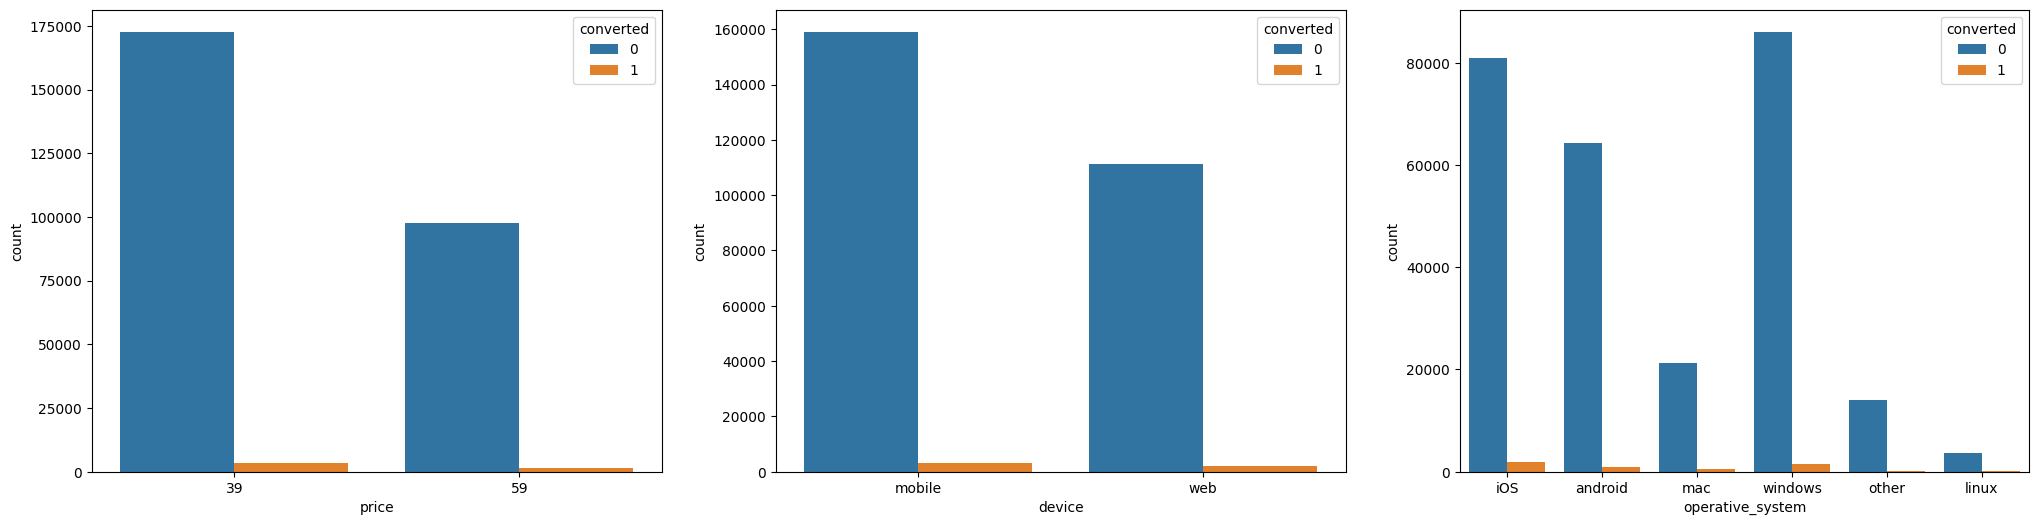

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
sns.countplot(x='price', hue='converted', data=data, ax=ax[0])
sns.countplot(x='device', hue='converted', data=data, ax=ax[1])
sns.countplot(x='operative_system', hue='converted', data=data, ax=ax[2])

<Axes: xlabel='device', ylabel='converted'>

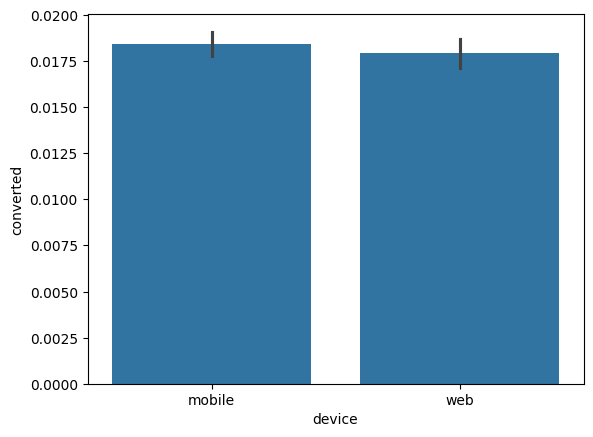

In [13]:
sns.barplot(x='device', y='converted', data=data)

- uniform across device -> no action on this

<Axes: xlabel='operative_system', ylabel='converted'>

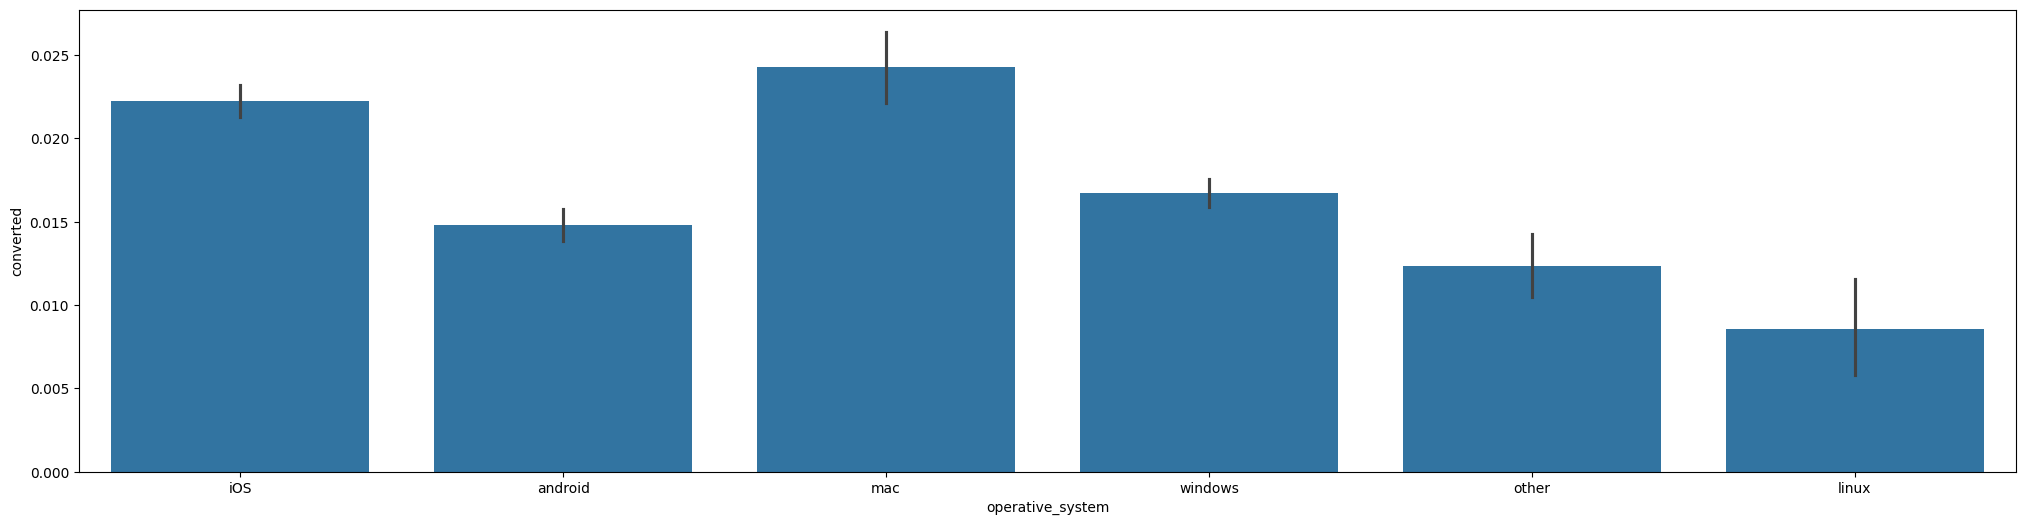

In [14]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.barplot(x='operative_system', y='converted', data=data)

- Apple users tend to have higher conversion rate -> look into this why to copy to windows and android
- linux seems to have awful rate and high variance -> could be UI/UX or performance issue on some linux variants

<Axes: xlabel='source', ylabel='count'>

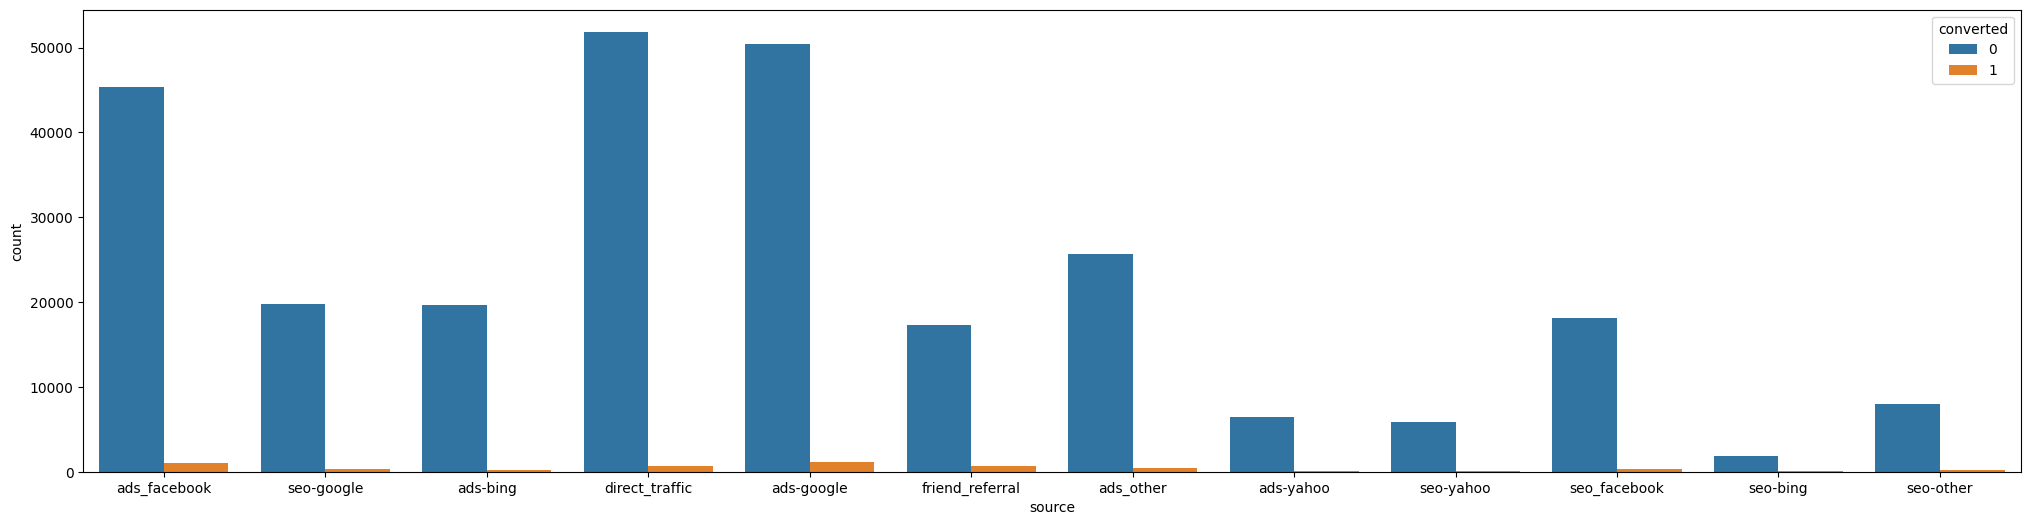

In [15]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.countplot(x='source', hue='converted', data=data)

<Axes: xlabel='source', ylabel='converted'>

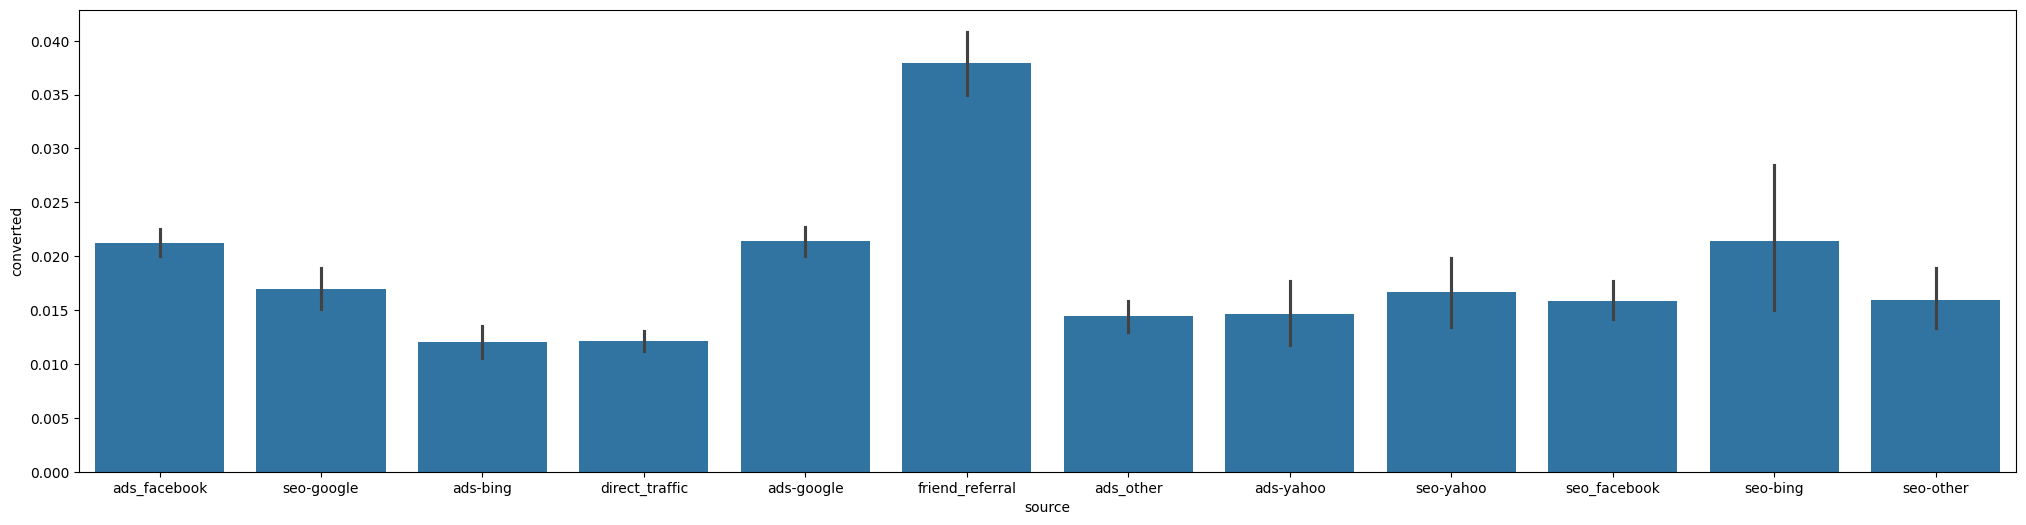

In [16]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.barplot(x='source', y='converted', data=data)

- friend_referral has much higher conversion rate than others -> encourage users who give referrals more bonus
- yahoo and bing ads don't perform well -> consider to shut them down to save cost

<Axes: xlabel='long', ylabel='lat'>

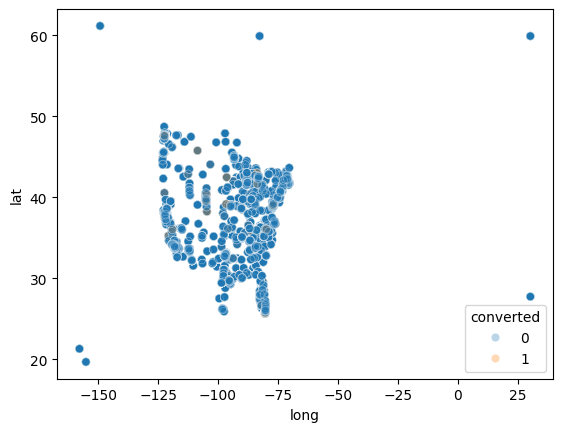

In [17]:
# plot 2D scatter plot on lag and long
sns.scatterplot(x='long', y='lat', data=data, hue='converted', alpha=0.3)

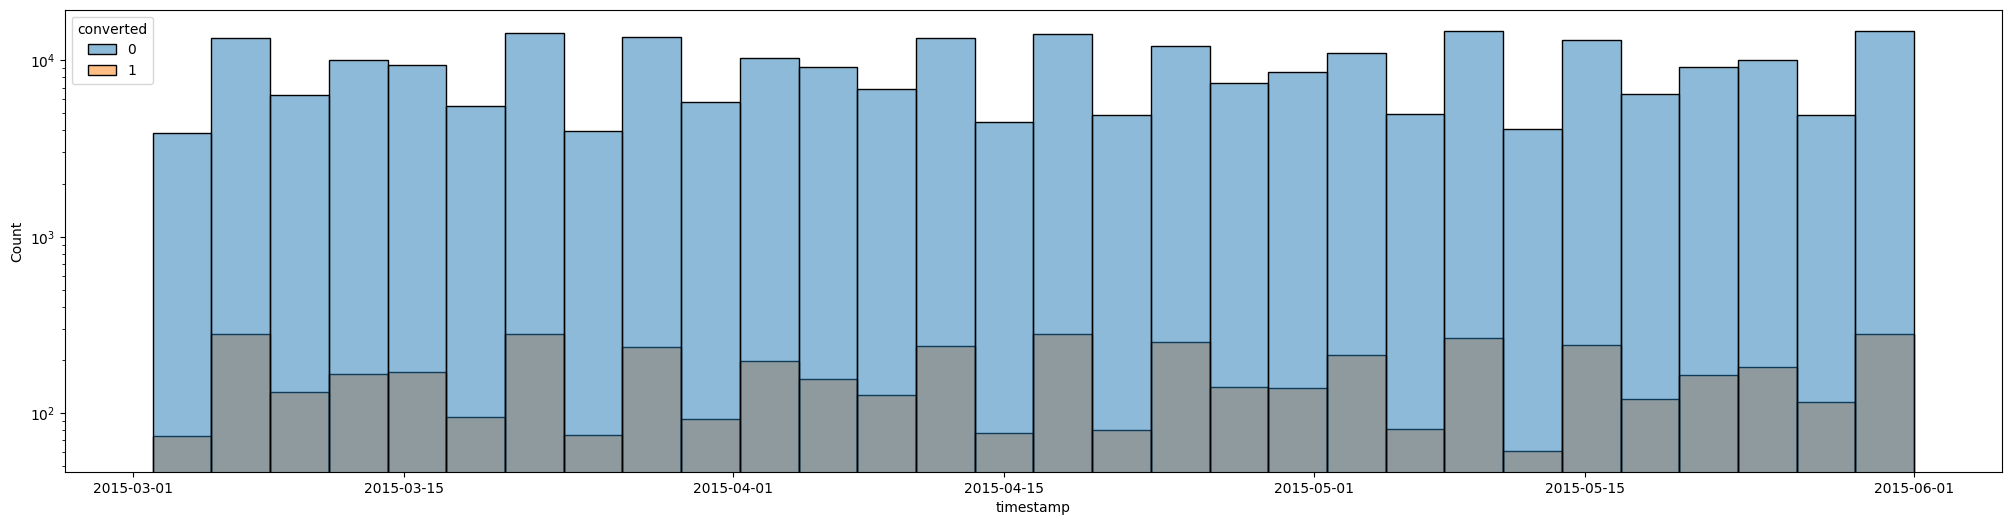

In [18]:
plt.figure(figsize=(25, 6))
sdata = sns.histplot(data=data, x='timestamp', hue='converted', bins=30);
plt.yscale('log')

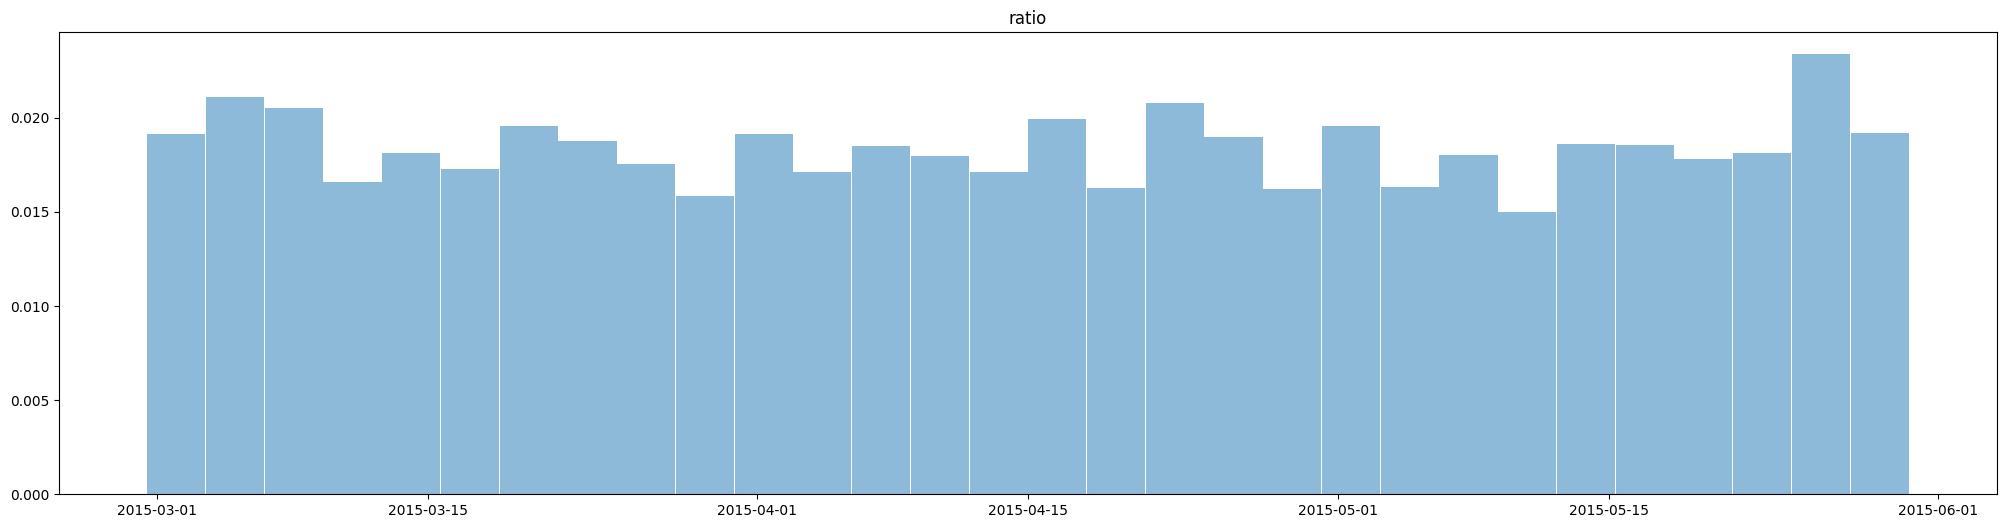

In [19]:
from util import histplot_ratio
histplot_ratio(sdata)

- seems uniform across all dates

In [20]:
data['weekday'] = data['timestamp'].dt.weekday + 1

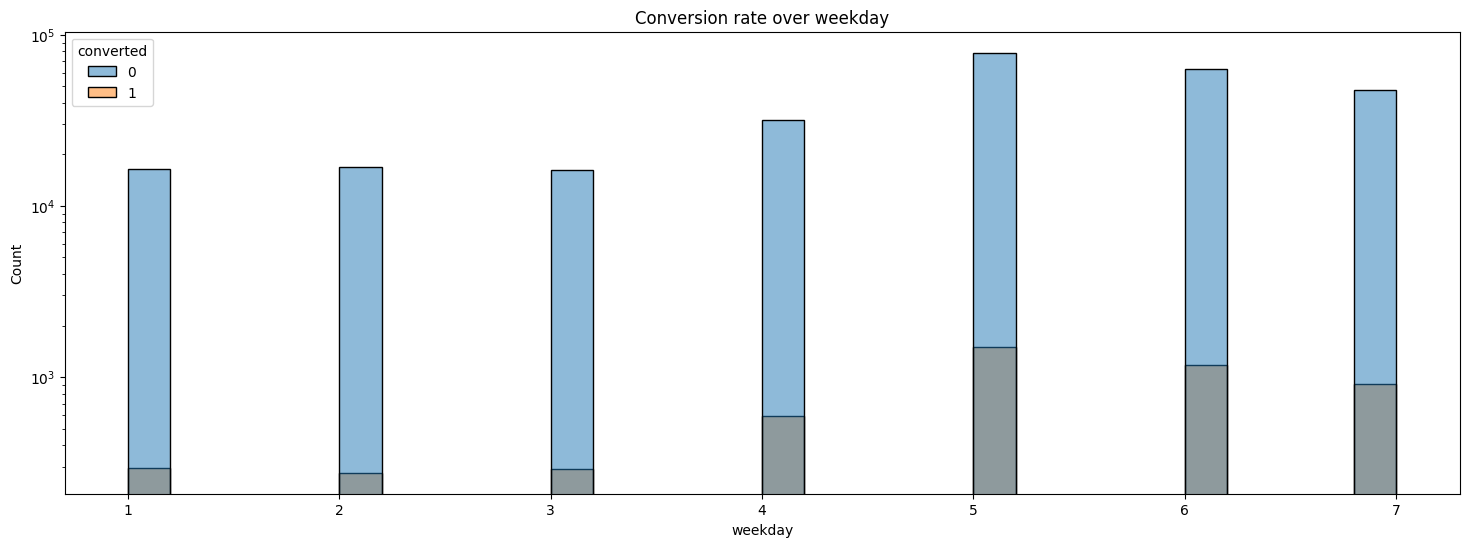

In [21]:
plt.figure(figsize=(18, 6))
sdata = sns.histplot(data=data, x='weekday', hue='converted', bins=30);
plt.title('Conversion rate over weekday')
plt.yscale('log')
# 1 is Monday, 7 is Sunday

In [22]:
# group by weekday
data.groupby('weekday')['converted'].mean()

weekday
1    0.017727
2    0.016141
3    0.017637
4    0.018347
5    0.018622
6    0.018093
7    0.018704
Name: converted, dtype: float64

- sortof uniform across weekday

# Stats test

In [23]:
treatment = data[data['test'] == 1]
control = data[data['test'] == 0]
control = control['converted'].to_numpy()
treatment = treatment['converted'].to_numpy()

In [24]:
from scipy.stats import ttest_ind

t = ttest_ind(control, treatment)
print(t.pvalue)

3.963794699853553e-16


- reject the hypothesis that the conversion rate is equal between control and treatment

But this doesn't consider the price difference, ie. higher price can have lower conversion rate to beat lower price

In [25]:
c_mean, c_std = np.mean(control), np.std(control)
t_mean, t_std = np.mean(treatment), np.std(treatment)
print('\t\tmean, std')
print('control', c_mean, c_std)
print('treatment', t_mean, t_std)

		mean, std
control 0.01976838533598879 0.13920343486134473
treatment 0.015446276235954489 0.1233194582634755


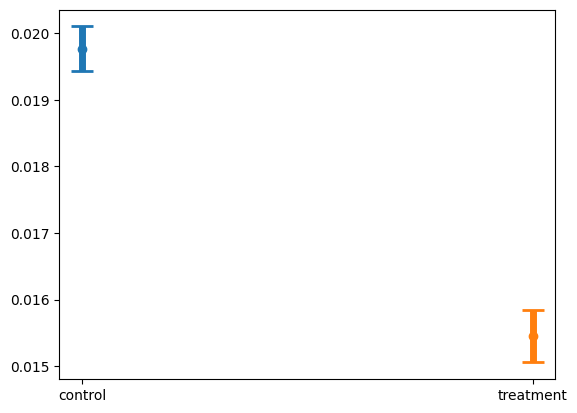

In [26]:
plt.errorbar('control', c_mean, yerr=c_std / np.sqrt(len(control)), fmt='o', label='control', capsize=8, capthick=2, lw=5)
plt.errorbar('treatment', t_mean, yerr=t_std / np.sqrt(len(treatment)), fmt='o', label='treatment', capsize=8, capthick=2, lw=5)
plt.show()

$x$ is the conversion rate, follow normal distribution
$$
\begin{align}
\bar{x_c} &\sim N\left(\mu_c, {\sigma_c \over \sqrt{n_c}}\right)\\
\bar{x_t} &\sim N\left(\mu_t, {\sigma_t \over \sqrt{n_t}}\right)
\end{align}
$$
$\mu$ is unbiased. When $N$ is large, $\sigma$ is also unbiased.
Thus we can scale $x_t$ and $x_c$ by a fixed constant

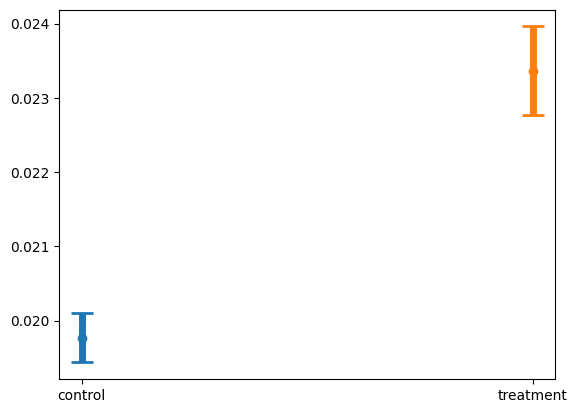

In [27]:
scale = 59/39
plt.errorbar('control', c_mean, yerr=c_std / np.sqrt(len(control)), fmt='o', label='control', capsize=8, capthick=2, lw=5)
plt.errorbar('treatment', t_mean*scale, yerr=scale*t_std / np.sqrt(len(treatment)), fmt='o', label='treatment', capsize=8, capthick=2, lw=5)
plt.show()

- reject the hypothesis that the sale is equal between control and treatment

-> **The company should sell at $59**